In [28]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import cartopy.crs as ccrs
import cartopy as cart
import matplotlib.patches as mpatches
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [16]:
# reading lat lon infomation
ds_land = xr.open_dataset('atmos.static.nc')
land = ds_land['land_mask']
# print(land.shape)
lat = ds_land['lat']
lon = ds_land['lon']
is_ocean = ds_land['land_mask'] < 0.1

In [29]:
varname  = 'R'

path1    = 'low_reso_A4p0/'
files1   = [f'{path1}pvalue_1.00/matrixa.{varname}_i_times_npatch_{month:02d}.nc'
         for month in range(1, 13)]
files2   = [f'{path1}matrixb_npatch_times_j_{month:02d}.nc'
         for month in range(1, 13)]

dsa = xr.open_mfdataset(files1, parallel=True, combine='nested',concat_dim=['month'])
dsb = xr.open_mfdataset(files2, parallel=True, combine='nested',concat_dim=['month'])

In [30]:
%%time
# dsa
jaco = np.empty((12,12960,12960))
for i in range(0,12):
    jaco[i,:,:] = np.matmul(dsa['dvar_dsst_p'][i,:,:].values,\
                            dsb['dsst_j_times_a_j_over_a_p_over_sig_dsst_j'][i,:,:].values)


CPU times: user 11.2 s, sys: 9.41 s, total: 20.6 s
Wall time: 21.5 s


In [31]:
jaco_mean = np.mean(jaco,axis=0)

In [32]:
%%time
jaco1_reshape = xr.DataArray(
    np.reshape(jaco_mean,(90,144,12960)),
    dims=["lat", "lon", "jj"],
    coords=dict(
        lon=lon,
        lat=lat,
    ),
)

weights = np.cos(np.deg2rad(lat))
jaco1_dm = jaco1_reshape.weighted(weights).mean(("lon", "lat")).astype(np.float32)
jaco1_map = xr.DataArray(
    np.reshape(np.array(jaco1_dm),(90,144)),
    dims=["lat", "lon"],
    coords=dict(
        lon=lon,
        lat=lat,
    ),
)
jaco1_map_mask = jaco1_map.where(is_ocean)

CPU times: user 974 ms, sys: 607 ms, total: 1.58 s
Wall time: 1.59 s


[-2.0000000e-03 -1.8000000e-03 -1.6000000e-03 -1.4000000e-03
 -1.2000000e-03 -1.0000000e-03 -8.0000000e-04 -6.0000000e-04
 -4.0000000e-04 -2.0000000e-04 -4.4408921e-19  2.0000000e-04
  4.0000000e-04  6.0000000e-04  8.0000000e-04  1.0000000e-03
  1.2000000e-03  1.4000000e-03  1.6000000e-03  1.8000000e-03
  2.0000000e-03]


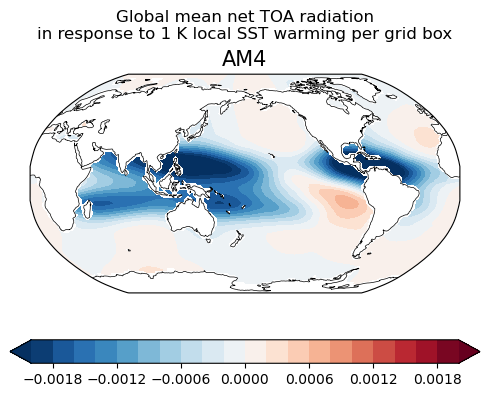

In [42]:
my_size  = 15
fig  = plt.figure(figsize=(5,4),dpi=100)
cmap = plt.colormaps['RdBu_r']
clevels = np.arange(-2.0,2.2,0.2)/1e3
print(clevels)

ax1 = plt.subplot(1,1,1,projection=ccrs.Robinson(central_longitude=180))
sp1 = ax1.contourf(lon, lat, jaco1_map_mask, levels=clevels,cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax1.coastlines(linewidth=0.5)

ax1.set_title('AM4',size = my_size)
cbar = plt.colorbar(sp1,ax=ax1,orientation='horizontal')
fig.suptitle('Global mean net TOA radiation\n'+
             'in response to 1 K local SST warming per grid box'
             ,fontsize=12,horizontalalignment='center')
plt.tight_layout()